In [9]:
#This is the notebook we use to generate the Fig.1 in our paper, this notebook is inspired by 
#https://keras.io/examples/vision/supervised-contrastive-learning/#1-supervised-contrastive-learning-loss-function
#to run this notebook, you need install tensorflow, tensorflow_addons as well as sklearn
import os 
from pathlib import Path
import random

import tensorflow as tf 
import tensorflow_addons as tfa
from tensorflow import keras 

import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA

import os 
%matplotlib inline

#We assume the Feature dict to have this structure
#  Feature/
#    |- Train
#       |- Genuine
#           /- LA_T_3100997.npz (This is the LFCC feature of the utterance LA_T_3100997.flac extracted by the baseline program of ASVspoof 2019 LA)
#           /- ...
#  	    |- Spoof
#           /- LA_T_3756331.npz
#           /- ...
#    |- Val
#       |- Genuine
#           /- ...
#  	    |- Spoof
#           /- ...
#    |- Test
#       |- Genuine
#           /- ...
#  	    |- Spoof
#           /- ...

In [10]:
base_path='/data/Feature/Train'
protocol_file='/data/ASVspoof2019.LA.cm.train.trn.txt'
genuine_file_path=os.path.join(base_path, 'Genuine')
spoof_file_path=os.path.join(base_path, 'Spoof')
with open(protocol_file) as f:
    infos=f.readlines()
mapping={info.split(' ')[1]:info.replace('\n', '').split(' ') for info in infos}
way_mapping={
    'A01':1, 
    'A01':2, 
    'A03':3, 
    'A04':4, 
    'A05':5, 
    'A06':6, 
    'A07':7, 
    'A08':8, 
    'A09':9, 
    'A10':10, 
    'A11':11, 
    'A12':12, 
    'A13':13, 
    'A14':14, 
    'A15':15, 
    'A16':16, 
    'A17':17, 
}
genuine_file_path=list(Path(genuine_file_path).glob('*.npz'))
spoof_file_path=list(Path(spoof_file_path).glob('*.npz'))

In [11]:
counter_spoof_file=random.sample(list(spoof_file_path), k=len(list(genuine_file_path)))
#choose the same number of LFCC features of spoofed utterances as that of genuine utterances to make a balanced dataset 

In [12]:
#to read .npz file into memory and find the shortest length of the LFCC features in our selected features
spoof_list=[]
for i in counter_spoof_file:
    name=i.name.replace('.npz', '')
    feature=np.load(i)['arr_0']
    bundle=(name, feature)
    spoof_list.append(bundle)

genuine_list=[]
for i in list(genuine_file_path):
    name=i.name.replace('.npz', '')
    feature=np.load(i)['arr_0']
    bundle=(name, feature)
    genuine_list.append(bundle)

short=512
for spoof in spoof_list:
    length=spoof[1].shape[0]
    if length < short:
        short=length
for genuine in genuine_list:
    length=genuine[1].shape[0]
    if length < short:
        short=length
short

67

In [13]:
#define the SCL, we directly copy this from https://keras.io/examples/vision/supervised-contrastive-learning/#1-supervised-contrastive-learning-loss-function
class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super(SupervisedContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)

In [14]:
loss=SupervisedContrastiveLoss(temperature=0.05)

In [15]:
#compute SCL of datasets of different length
def compute_loss(pca_dim, shortest):
    los=[]
    for i in range(int(pca_dim/60), shortest+1):
        for_plot=[]

        for bundle in spoof_list:
            name=bundle[0]
            feature=bundle[1]
            frames=feature.shape[0]
            index_start=0
            using_feature=feature[index_start:index_start+i, :]
            target=1
            bundle=(using_feature, target)
            for_plot.append(bundle)


        for bundle in genuine_list:
            name=bundle[0]
            feature=bundle[1]
            frames=feature.shape[0]
            index_start=0
            using_feature=feature[index_start:index_start+i, :]
            target=0
            bundle=(using_feature, target)
            for_plot.append(bundle)

        a, b=[], []
        for j in range(len(for_plot)):
            a.append(for_plot[j][0])
            b.append(for_plot[j][1])
        arr=np.array(a, dtype=np.float32).reshape(5160, -1)
        new_a=PCA(n_components=pca_dim).fit_transform(arr)
        tensor_a=tf.constant(new_a, dtype=tf.float32)
        tenosr_b=tf.constant(b, dtype=tf.float32)
        feature=tf.reshape(tensor_a, shape=(5160, -1))
        value=loss(tenosr_b, feature).numpy()
        los.append(value)
    return np.array(los)


In [16]:
#calculate this loss for many times to avoid possible numerical errors
def sampling(pca_dim, shortest, samples=60):
    total_loss=np.zeros(shape=(shortest+1-pca_dim//60, ), dtype=np.float32)
    for _ in range(samples):
        los=compute_loss(pca_dim, shortest)
        total_loss+=los
    return total_loss/samples

# sampling(180, 65, 2).shape

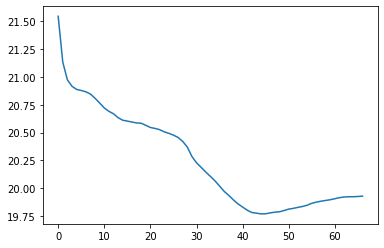

In [17]:
#samples=1 for smoke-test
a=sampling(60, short, 1)
plt.plot(a)
# array([21.522217, 21.123184, 20.978636, 20.910416, 20.87409 , 20.855097,
#     20.844511, 20.826216, 20.794949, 20.757719, 20.715427, 20.683243,
#     20.654678, 20.609268, 20.577244, 20.56762 , 20.559587, 20.554028,
#     20.548992, 20.532965, 20.515858, 20.511631, 20.508186, 20.494783,
#     20.481657, 20.469555, 20.449566, 20.415064, 20.366112, 20.29015 ,
#     20.241735, 20.206081, 20.164122, 20.121264, 20.07475 , 20.026148,
#     19.974396, 19.933092, 19.890413, 19.852352, 19.822243, 19.795166,
#     19.78155 , 19.775568, 19.77166 , 19.771927, 19.778786, 19.78453 ,
#     19.789854, 19.801006, 19.814644, 19.822136, 19.831566, 19.843311,
#     19.858652, 19.87511 , 19.885893, 19.894947, 19.902826, 19.908686,
#     19.917107, 19.926258, 19.934507, 19.936892, 19.936365],
#     dtype=float32)

In [ ]:
b=sampling(120, short, 100)
# array([21.097296, 20.928377, 20.817253, 20.744236, 20.700178, 20.673655,
#        20.64334 , 20.605518, 20.56773 , 20.527596, 20.494265, 20.462645,
#        20.42074 , 20.386883, 20.373096, 20.360886, 20.3515  , 20.34234 ,
#        20.32536 , 20.306707, 20.30042 , 20.292835, 20.278442, 20.265417,
#        20.250805, 20.229948, 20.193758, 20.144403, 20.067535, 20.016518,
#        19.977465, 19.933535, 19.8881  , 19.837147, 19.782572, 19.72631 ,
#        19.680334, 19.63247 , 19.589724, 19.555426, 19.523794, 19.502132,
#        19.490362, 19.482433, 19.481913, 19.487122, 19.49326 , 19.50129 ,
#        19.512474, 19.52678 , 19.536047, 19.548637, 19.563725, 19.581848,
#        19.600828, 19.615416, 19.628656, 19.641958, 19.653297, 19.667889,
#        19.683592, 19.694887, 19.703693, 19.708015], dtype=float32)

In [ ]:
#we choose 60 here to reduce the computation time
sampling(180, short, 60)
# array([20.928394, 20.817251, 20.739382, 20.687216, 20.649586, 20.609169,
#        20.56354 , 20.519043, 20.474443, 20.438   , 20.404505, 20.361128,
#        20.326286, 20.310675, 20.295412, 20.284178, 20.272837, 20.254536,
#        20.235962, 20.228611, 20.219383, 20.203674, 20.18978 , 20.174437,
#        20.152134, 20.115072, 20.064825, 19.987852, 19.936275, 19.896858,
#        19.852089, 19.806501, 19.75445 , 19.699453, 19.643366, 19.59709 ,
#        19.54877 , 19.50431 , 19.468105, 19.43395 , 19.408   , 19.392189,
#        19.380388, 19.376055, 19.376692, 19.379065, 19.38375 , 19.392857,
#        19.40464 , 19.412865, 19.424658, 19.43964 , 19.457191, 19.475262,
#        19.490425, 19.504164, 19.51871 , 19.531963, 19.547993, 19.5651  ,
#        19.577978, 19.588915, 19.59575 ], dtype=float32)